In [4]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn import preprocessing

We start by defining a (possibly) multi-variate function and plot it in 1
dimension. 

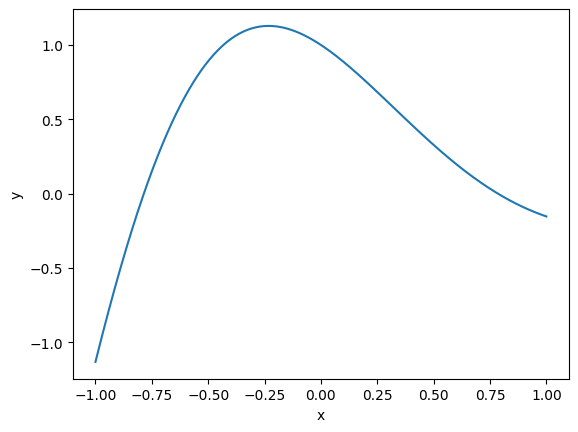

In [5]:
# function to approximate 
def f(x):
    return jnp.cos(2*jnp.prod(x, axis=1))*jnp.exp(-x[:,0])

# example in one dimension
x = jnp.linspace(-1,1,1000).reshape(-1,1)
y = f(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [6]:
# A class for doing a regression problem.
class Regression(nn.Module):
    num_features: int
    
    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
        self.shift = self.param('bias', jax.nn.initializers.glorot_uniform(),
                                (1,1))
    @nn.compact
    def __call__(self, x):
        out = jnp.sum(x*self.w[:,0], axis=1)
        return out + self.shift
# initializing the optimizer
learning_rate = 8e-1
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting a single-variate function

In [7]:
#training data
x = jnp.linspace(-1,1,500).reshape(-1,1)
y = f(x)

deg_poly = 70 #degree of the polynomial
x_poly = generate_poly(deg_poly, x)
scaler = preprocessing.StandardScaler().fit(x_poly)
x_poly = scaler.transform(x_poly)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model = Regression(deg_poly + 1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 2000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 1.921583890914917
epoch: 100, loss function: 0.010698391124606133
epoch: 200, loss function: 0.000419031159253791
epoch: 300, loss function: 0.0003490371454972774
epoch: 400, loss function: 13.079545021057129
epoch: 500, loss function: 0.0006516912253573537
epoch: 600, loss function: 0.00026263942709192634
epoch: 700, loss function: 0.0032043266110122204
epoch: 800, loss function: 0.0018222072394564748
epoch: 900, loss function: 0.00021261493384372443
epoch: 1000, loss function: 0.00019756688561756164
epoch: 1100, loss function: 0.03013700246810913
epoch: 1200, loss function: 0.00017291275435127318
epoch: 1300, loss function: 0.00016127080016303807
epoch: 1400, loss function: 0.14882682263851166
epoch: 1500, loss function: 0.00014761032070964575
epoch: 1600, loss function: 0.00013275534729473293
epoch: 1700, loss function: 0.3359617590904236
epoch: 1800, loss function: 0.00012515988782979548
epoch: 1900, loss function: 0.00011040054960176349


We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

training error: 0.015805065631866455, test error: 0.014691521413624287
(500, 1)


Text(0.5, 1.0, 'Functions on all data')

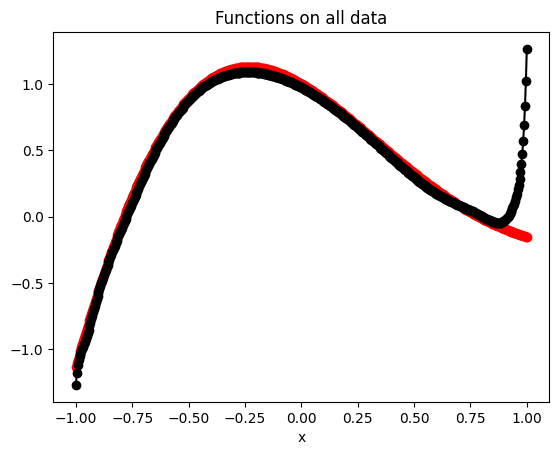

In [8]:
# evaluate the training and test errors 
tr_error = MSE(params, x_train, y_train)
te_error = MSE(params, x_test, y_test)
print(f"training error: {tr_error}, test error: {te_error}")
y_pred = model.apply(params, x_poly).T
print(y_pred.shape)
# plotting the true and predicted signal on training data 
plt.plot(x, y, marker='o', color='r', label="True function")
plt.plot(x, y_pred, marker='o', color='black', label="Approximate function")
plt.xlabel('x')
plt.title("Functions on all data")

An important question here is how complex need the approximating function be for to gain a certain accuracy. We study this question:

In [9]:
def Trainer(deg_poly, params):
    """
    Performs a full training procedure where the complexity of the training model is determined by the degree of the polynomial.
    """

    opt_state = optx.init(params)
    n_epochs = 2000 #number of training epochs 
    for e in range(n_epochs):
        loss_val, grad = loss_grad_fn(params, x_train, y_train)
        updates, opt_state = optx.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        if e % 500 == 0:
            print(f"epoch: {e}, loss function: {loss_val}")
            
    # compute training and testing errors
    
    tr_error = MSE(params, x_train, y_train)
    te_error = MSE(params, x_test, y_test)
    
    return tr_error, te_error

tr_errors = []
te_errors = []

deg_poly_list = np.linspace(2,25,5,dtype=int)
for deg_poly in deg_poly_list:
    x_poly = generate_poly(deg_poly, x)
    #putting the features on the same scale
    scaler = preprocessing.StandardScaler().fit(x_poly)
    x_poly = scaler.transform(x_poly)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)
    model = Regression(deg_poly + 1)
    params = model.init(jax.random.PRNGKey(0), x_test)
    tr_err, te_err = Trainer(deg_poly, params)
    tr_errors.append(tr_err)
    te_errors.append(te_err)
    print(f"training of for polynomial degree: {deg_poly} is done")

epoch: 0, loss function: 1.7015118598937988
epoch: 500, loss function: 0.046297263354063034
epoch: 1000, loss function: 0.04629776254296303
epoch: 1500, loss function: 0.046297263354063034
training of for polynomial degree: 2 is done
epoch: 0, loss function: 2.086591958999634
epoch: 500, loss function: 0.00018881070718634874
epoch: 1000, loss function: 3.3945241739274934e-05
epoch: 1500, loss function: 3.1887202567304485e-06
training of for polynomial degree: 7 is done
epoch: 0, loss function: 1.9829014539718628
epoch: 500, loss function: 7.211211050162092e-05
epoch: 1000, loss function: 2.8323138394625857e-05
epoch: 1500, loss function: 1.5170317965385038e-05
training of for polynomial degree: 13 is done
epoch: 0, loss function: 2.301536798477173
epoch: 500, loss function: 4.812645784113556e-05
epoch: 1000, loss function: 3.0830873583909124e-05
epoch: 1500, loss function: 1.9382894606678747e-05
training of for polynomial degree: 19 is done
epoch: 0, loss function: 1.9820833206176758
e

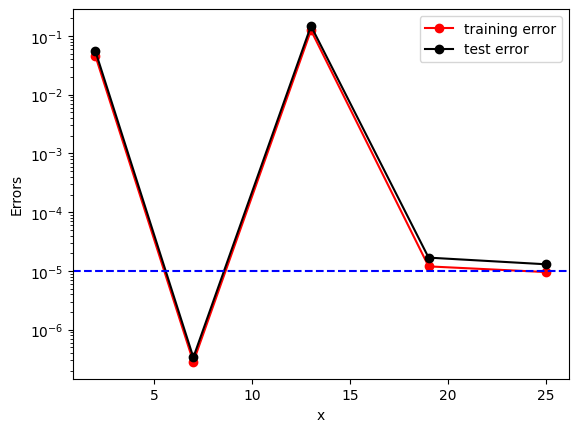

In [10]:

# plotting both errors 
plt.plot(deg_poly_list, tr_errors, marker="o", color='r', label="training error")
plt.plot(deg_poly_list, te_errors, marker="o", color='black', label="test error")
plt.axhline(y=1e-5, color='b', linestyle='--')
plt.xlabel("x")
plt.yscale('log')
plt.ylabel("Errors")
plt.legend()
plt.show()

## Fitting a multi-variate function

In [11]:
x = jnp.linspace(-1,1,500)#.reshape(-1,1)
elems = jnp.meshgrid(x,x)
# Flatten the arrays and concatenate them to get the direct product
x_mD = np.vstack([elem.ravel() for elem in elems]).T
y = f(x_mD)

In [12]:
def Trainer(deg_poly, params):
    """
    Performs a full training procedure where the complexity of the training model is determined by the degree of the polynomial.
    """

    opt_state = optx.init(params)
    n_epochs = 2000 #number of training epochs 
    for e in range(n_epochs):
        loss_val, grad = loss_grad_fn(params, x_train, y_train)
        updates, opt_state = optx.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        if e % 500 == 0:
            print(f"epoch: {e}, loss function: {loss_val}")
            
    # compute training and testing errors
    
    tr_error = MSE(params, x_train, y_train)
    te_error = MSE(params, x_test, y_test)
    
    return tr_error, te_error

tr_errors = []
te_errors = []

deg_poly_list = np.linspace(2,25,5, dtype=int)
nfuncs = []
for deg_poly in deg_poly_list:
    x_poly = generate_poly(deg_poly, x_mD)
    scaler = preprocessing.StandardScaler().fit(x_poly)
    x_poly = scaler.transform(x_poly)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)
    nfuncs.append(x_poly.shape[1])
    model = Regression(x_poly.shape[1])
    params = model.init(jax.random.PRNGKey(0), x_test)
    tr_err, te_err = Trainer(deg_poly, params)
    tr_errors.append(tr_err)
    te_errors.append(te_err)
    print(f"training of for polynomial degree: {deg_poly} is done")


epoch: 0, loss function: 2.5837583541870117
epoch: 500, loss function: 0.08958480507135391
epoch: 1000, loss function: 0.08958480507135391
epoch: 1500, loss function: 0.09835397452116013
training of for polynomial degree: 2 is done
epoch: 0, loss function: 1.743695855140686
epoch: 500, loss function: 8.309475379064679e-05
epoch: 1000, loss function: 4.37734488514252e-05
epoch: 1500, loss function: 3.659575304482132e-05
training of for polynomial degree: 7 is done
epoch: 0, loss function: 3.1696205139160156
epoch: 500, loss function: 0.0005247328663244843
epoch: 1000, loss function: 0.0001470582210458815
epoch: 1500, loss function: 5.8315639762440696e-05
training of for polynomial degree: 13 is done
epoch: 0, loss function: 3.3265328407287598
epoch: 500, loss function: 0.003446959424763918
epoch: 1000, loss function: 0.0007832787232473493
epoch: 1500, loss function: 0.00039615060086362064
training of for polynomial degree: 19 is done
epoch: 0, loss function: 2.1331465244293213
epoch: 50

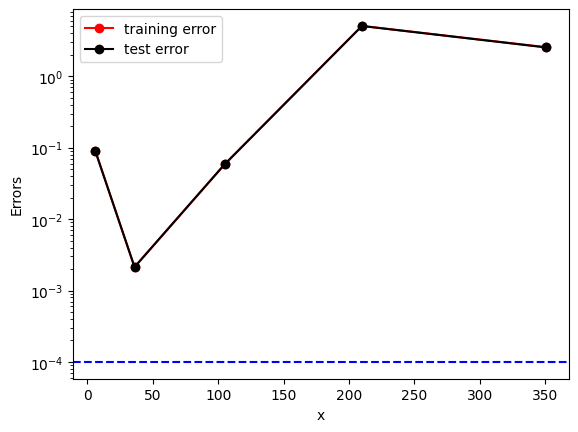

In [13]:

# plotting both errors 
plt.plot(nfuncs, tr_errors, marker="o", color='r', label="training error")
plt.plot(nfuncs, te_errors, marker="o", color='black', label="test error")
plt.axhline(y=1e-4, color='b', linestyle='--')
plt.xlabel("x")
plt.ylabel("Errors")
plt.yscale("log")
plt.legend()
plt.show()

One might argue that the curse of dimensionality is resulting from the fact that the basis we are using in multiple dimensions is a direct-product basis. To test the influence of this we not try to evaluate the accuracy of the model using a dimension-free prunning of the direct-product basis set. This prunnign is based on randomly sampling a subset of the full-direct product basis. 

In [14]:
def Trainer(deg_poly, params):
    """
    Performs a full training procedure where the complexity of the training model is determined by the degree of the polynomial.
    """

    opt_state = optx.init(params)
    n_epochs = 8000 #number of training epochs 
    for e in range(n_epochs):
        loss_val, grad = loss_grad_fn(params, x_train, y_train)
        updates, opt_state = optx.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        if e % 500 == 0:
            print(f"epoch: {e}, loss function: {loss_val}")
            
    # compute training and testing errors
    
    tr_error = MSE(params, x_train, y_train)
    te_error = MSE(params, x_test, y_test)
    
    return tr_error, te_error

tr_errors = []
te_errors = []

deg_poly_list = np.linspace(2,25,5, dtype=int)
nfuncs = []
for deg_poly in deg_poly_list:
    x_poly = generate_poly(deg_poly, x_mD)
    # we now select subset of these poly features 
    indices = np.random.randint(0, x_poly.shape[1], deg_poly)
    x_poly = x_poly[:, indices]
    scaler = preprocessing.StandardScaler().fit(x_poly)
    x_poly = scaler.transform(x_poly)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)
    nfuncs.append(x_poly.shape[1])
    model = Regression(x_poly.shape[1])
    params = model.init(jax.random.PRNGKey(0), x_test)
    tr_err, te_err = Trainer(deg_poly, params)
    tr_errors.append(tr_err)
    te_errors.append(te_err)
    print(f"training of for polynomial degree: {deg_poly} is done")


epoch: 0, loss function: 3.939579725265503
epoch: 500, loss function: 0.26689571142196655
epoch: 1000, loss function: 0.26689571142196655
epoch: 1500, loss function: 0.26689571142196655
epoch: 2000, loss function: 0.2857011556625366
epoch: 2500, loss function: 0.2678978741168976
epoch: 3000, loss function: 0.2669491171836853
epoch: 3500, loss function: 0.26832589507102966
epoch: 4000, loss function: 0.26748231053352356
epoch: 4500, loss function: 0.26752227544784546
epoch: 5000, loss function: 0.2669048607349396
epoch: 5500, loss function: 0.2674099802970886
epoch: 6000, loss function: 0.2668980062007904
epoch: 6500, loss function: 0.26706454157829285
epoch: 7000, loss function: 0.2669979929924011
epoch: 7500, loss function: 0.2670276165008545
training of for polynomial degree: 2 is done
epoch: 0, loss function: 3.892681360244751
epoch: 500, loss function: 0.14881248772144318
epoch: 1000, loss function: 0.14881250262260437
epoch: 1500, loss function: 0.15250326693058014
epoch: 2000, lo

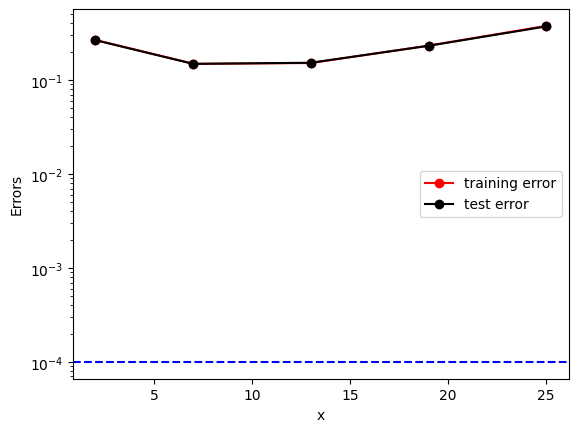

In [15]:
# plotting both errors 
plt.plot(nfuncs, tr_errors, marker="o", color='r', label="training error")
plt.plot(nfuncs, te_errors, marker="o", color='black', label="test error")
plt.axhline(y=1e-4, color='b', linestyle='--')
plt.xlabel("x")
plt.ylabel("Errors")
plt.yscale("log")
plt.legend()
plt.show()

# Extending the codes
Here is a list of things you can do to improve this notebook, or your understanding thereof:

- In the multi-dimensional case plot the projection of the approximate and true functions on each dimension. This would help get a visual understanding of how good the approximation is. 